In [15]:
##load the data from "trading_data.parquet" print the last 5 rows of teh data 
import pandas as pd
data = pd.read_parquet("real_trade_data.parquet")
print(data.tail(5))
data = pd.DataFrame(columns=data.columns)
print(data)

#save the new data to a new file called "real_trade_data.parquet"
data.to_parquet("real_trade_data.parquet")


Empty DataFrame
Columns: [Symbol, LastBuySignalDate, LastBuySignalPrice, IsCurrentlyBought, ConsecutiveLosses, LastTradedDate, UpProbability, LastSellPrice, PositionSize]
Index: []
Empty DataFrame
Columns: [Symbol, LastBuySignalDate, LastBuySignalPrice, IsCurrentlyBought, ConsecutiveLosses, LastTradedDate, UpProbability, LastSellPrice, PositionSize]
Index: []


In [14]:
import pandas as pd

# Read the current trading data
df = pd.read_parquet('trading_data.parquet')

# Modify the last row (assuming XPEV is the last row)
df.loc[df['Symbol'] == 'XPEV', 'LastBuySignalDate'] = '2024-09-04'
df.loc[df['Symbol'] == 'XPEV', 'IsCurrentlyBought'] = False
df.loc[df['Symbol'] == 'XPEV', 'UpProbability'] = 0.7536
df.loc[df['Symbol'] == 'XPEV', 'LastTradedDate'] = '2024-09-04'

# Save the modified DataFrame back to the parquet file
df.to_parquet('trading_data.parquet')

In [48]:
import os
import random
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Load the original data and prepare it, including lag features
def load_random_stock_data(input_directory):
    """
    Load a random .parquet file from the specified input directory and generate the necessary lag features.
    """
    # List all files in the directory
    all_files = [f for f in os.listdir(input_directory) if f.endswith('.parquet')]
    
    # Randomly select one file
    selected_file = random.choice(all_files)
    
    # Load the parquet file
    file_path = os.path.join(input_directory, selected_file)
    df = pd.read_parquet(file_path)
    
    # Ensure the 'Date' column is of datetime type
    if 'Date' not in df.columns and df.index.name == 'Date':
        df = df.reset_index()
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Retain only the OHLCV columns
    df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
    
    # Generate lag features for 'High', 'Low', and 'Volume'
    for col in ['High', 'Low', 'Volume']:
        lag_times = [1, 2, 3] if col == 'Volume' else [2, 5]
        for lag in lag_times:
            df[f'{col}_Lag{lag}'] = df[col].shift(lag)

    # Drop rows with NaN values (as these arise from lagging)
    df = df.dropna()

    print(f"Loaded and prepared file: {selected_file}")
    
    return df

# Example custom function (translated formula from logs)
def translated_formula(df):
    """
    Example of a translated formula from logs.
    Formula: div(Low_Lag2, add(High_Lag2, div(div(0.791, Low), High)))
    Translated into Python below.
    """
    #    1st    result = df['Low_Lag2'] / (df['High_Lag2'] + ((0.791 / df['Low']) / df['High']))

    #result = abs(-0.982) - (df['Low_Lag2'] / df['High_Lag2']) / (df['High'] / df['Low'])



    #result = (df['Low'] / df['High']) + abs(df['Low_Lag5'] / df['High_Lag5'])
    result = (abs(df['Low_Lag2'] / df['High_Lag2'])) / ((df['High_Lag5'] / df['Low_Lag5']) / -0.2831)

    return result


def calculate_rsi(df, window=14):
    """
    Calculate the Relative Strength Index (RSI) for the given dataframe.
    RSI is a momentum indicator that measures the speed and change of price movements.
    """
    delta = df['Close'].diff()  # Difference between consecutive close prices
    gain = np.where(delta > 0, delta, 0)  # Gains (only positive price changes)
    loss = np.where(delta < 0, -delta, 0)  # Losses (absolute value of negative price changes)

    # Calculate average gain and loss over the window period
    avg_gain = pd.Series(gain).rolling(window=window, min_periods=1).mean()
    avg_loss = pd.Series(loss).rolling(window=window, min_periods=1).mean()

    # Calculate the relative strength (RS)
    rs = avg_gain / avg_loss

    # Calculate RSI using the formula: 100 - (100 / (1 + RS))
    rsi = 100 - (100 / (1 + rs))

    return rsi



# Function to plot stock price percentage changes, formula output percentage changes, and RSI using Plotly
def plot_stock_formula_and_rsi(df, formula):
    """
    Plot stock price percentage changes, formula output percentage changes, and RSI using Plotly.
    Calculate and print concordance between stock price and formula output.
    """
    # Apply the custom formula to the stock data
    transformed_data = formula(df)

    # Calculate percentage change for stock price ('Close') and formula output
    df['Close_Pct_Change'] = df['Close'].pct_change() * 100  # Convert to percentage
    formula_pct_change = transformed_data.pct_change() * 100  # Convert to percentage

    # Calculate RSI and its percentage change
    df['RSI'] = calculate_rsi(df)
    rsi_pct_change = df['RSI'].pct_change() * 100  # Convert to percentage

    # Drop NaN values that arise from pct_change and RSI calculation
    df = df.dropna(subset=['Close_Pct_Change', 'RSI'])
    formula_pct_change = formula_pct_change.dropna()
    rsi_pct_change = rsi_pct_change.dropna()

    # Reindex stock_pct_change to align with the index of formula_pct_change
    stock_pct_change = df['Close_Pct_Change'].reindex(formula_pct_change.index)

    # Calculate concordance for the stock price and the formula output
    stock_up = stock_pct_change > 0  # Stock price is going up
    formula_up = formula_pct_change > 0    # Formula output is going up

    concordant = (stock_up == formula_up).sum()  # Number of times they move together
    total = len(stock_up)                        # Total number of observations
    concordance_percentage = (concordant / total) * 100  # Calculate percentage of concordance

    # Print the concordance percentage
    print(f"Concordance (moving together) between stock and formula: {round(concordance_percentage, 2)}%")

    # Create the plot
    fig = go.Figure()

    # Add stock price percentage change trace
    fig.add_trace(go.Scatter(x=df['Date'], y=df['Close_Pct_Change'], mode='lines', name='Stock Price % Change'))

    # Add formula output percentage change trace
    fig.add_trace(go.Scatter(x=df['Date'], y=formula_pct_change, mode='lines', name='Formula Output % Change'))

    # Add RSI percentage change trace
    fig.add_trace(go.Scatter(x=df['Date'], y=rsi_pct_change, mode='lines', name='RSI % Change', line=dict(dash='dash')))

    # Update layout for better visualization
    fig.update_layout(
        title="Stock Price, Formula Output, and RSI % Change",
        xaxis_title="Date",
        yaxis_title="Percentage Change (%)",
        legend_title="Legend",
        hovermode="x unified"
    )

    # Show the plot
    fig.show()

# Define the directory with stock market data files
input_directory = 'Data/PriceData'

# Load a random stock data sample
df = load_random_stock_data(input_directory)

# Plot the stock data along with the translated formula output and RSI
plot_stock_formula_and_rsi(df, translated_formula)


Loaded and prepared file: D.parquet
Concordance (moving together) between stock and formula: 49.66%


{'pollster': 68, 'date': 76, 'Harris': 73, 'Trump': 83}


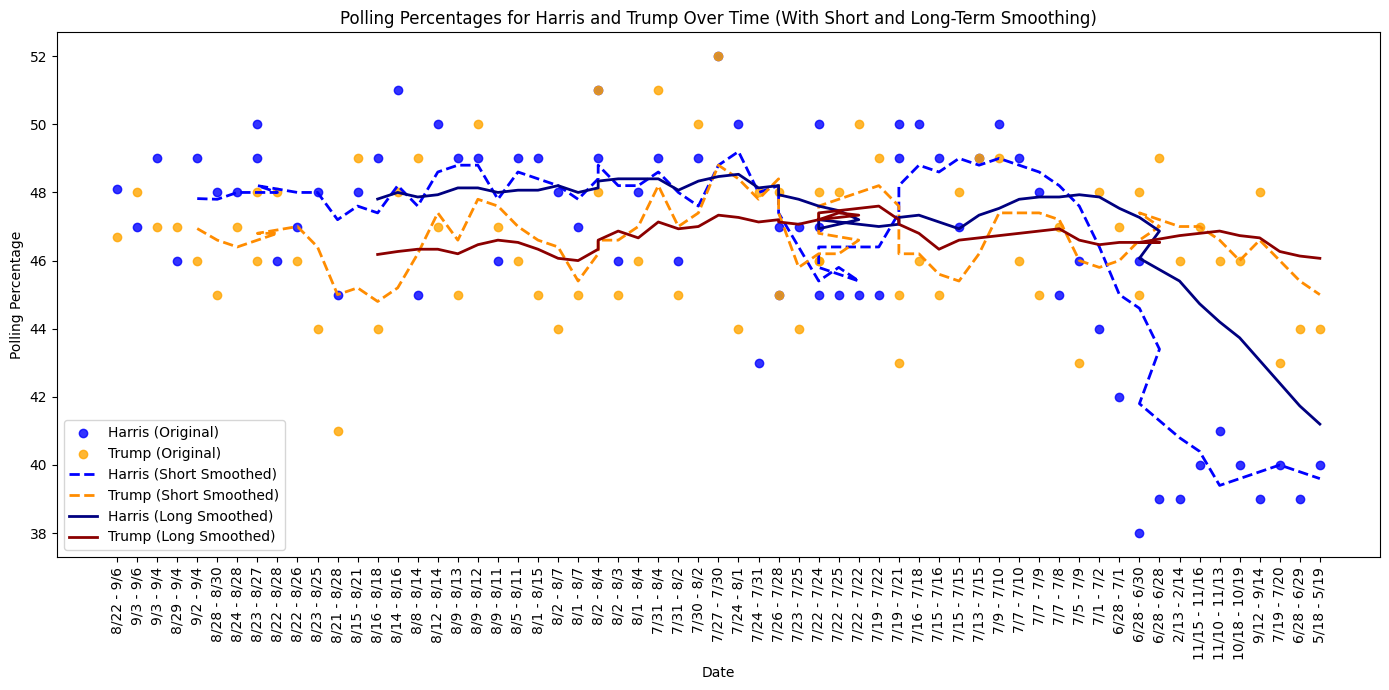

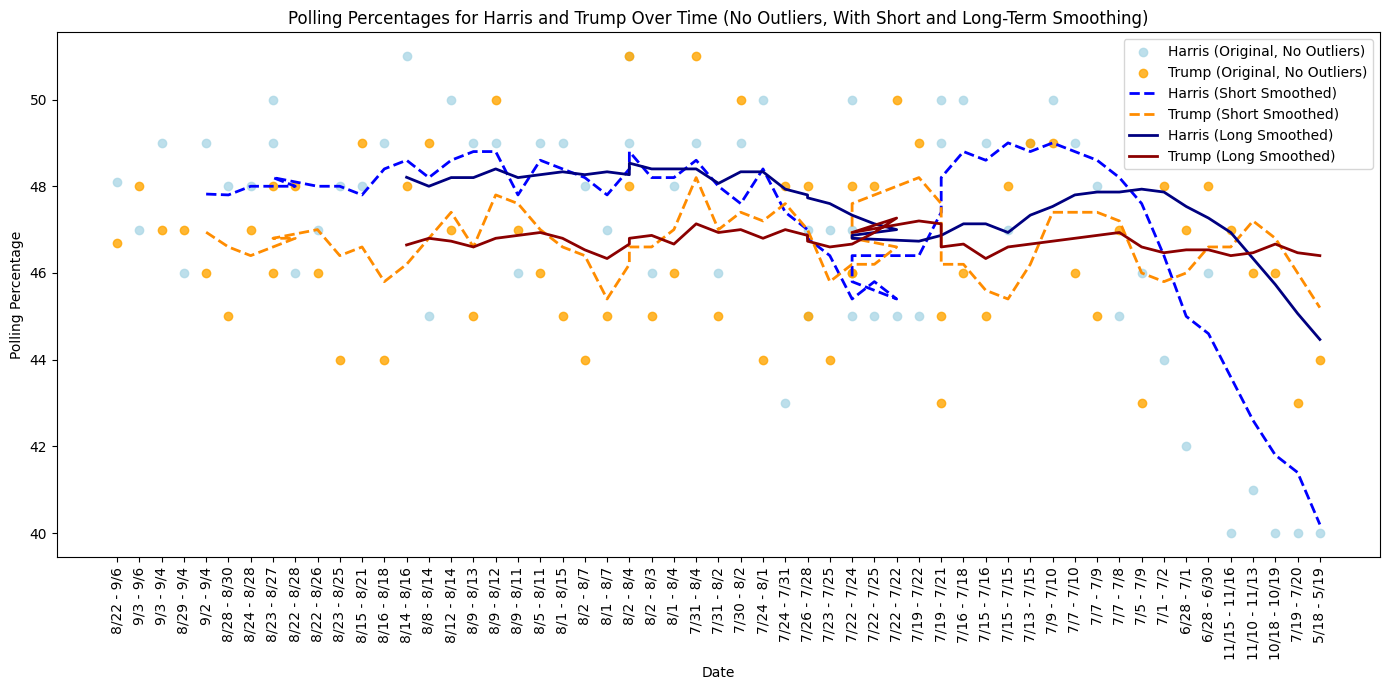

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Data
data = {
    'pollster': ['RCP Average', 'NY Times/Siena', 'Emerson', 'Rasmussen Reports', 'Morning Consult', 
                 'I&I/TIPP', 'Wall Street Journal', 'Quinnipiac', 'Rasmussen Reports', 'ABC News/Ipsos', 
                 'Yahoo News', 'Morning Consult', 'Reuters/Ipsos', 'Rasmussen Reports', 'Morning Consult', 
                 'CBS News', 'Rasmussen Reports', 'Emerson', 'ABC News/Wash Post', 'FOX News', 
                 'Morning Consult', 'Pew Research', 'Data for Progress (D)**', 'Ipsos', 
                 'Rasmussen Reports', 'SurveyUSA', 'Morning Consult', 'HarrisX', 'NPR/PBS/Marist', 
                 'CNBC', 'I&I/TIPP', 'CBS News', 'Daily Kos/Civiqs', 'Marquette', 'Rasmussen Reports', 
                 'Harvard-Harris', 'Reuters/Ipsos', 'Morning Consult', 'Wall Street Journal', 
                 'NY Times/Siena', 'Forbes/HarrisX', 'NPR/PBS/Marist', 'Rasmussen Reports', 'CNN', 
                 'Reuters/Ipsos', 'Morning Consult', 'Yahoo News', 'Quinnipiac', 'Forbes/HarrisX', 
                 'CBS News', 'Reuters/Ipsos', 'Emerson', 'Harvard-Harris', 'FOX News', 
                 'Harvard-Harris', 'Yahoo News', 'Harvard-Harris', 'Rasmussen Reports', 
                 'PPP (D)', 'Harvard-Harris', 'Federalist/Susquehanna', 'Harvard-Harris', 'Federalist/Susquehanna', 
                 'Harvard-Harris', 'Federalist/Susquehanna', 'Harvard-Harris', 'Federalist/Susquehanna', 
                 'Harvard-Harris'],
    'date': ['8/22 - 9/6', '9/3 - 9/6', '9/3 - 9/4', '8/29 - 9/4', '9/2 - 9/4', '8/28 - 8/30', 
             '8/24 - 8/28', '8/23 - 8/27', '8/22 - 8/28', '8/23 - 8/27', '8/22 - 8/26', 
             '8/23 - 8/25', '8/21 - 8/28', '8/15 - 8/21', '8/16 - 8/18', '8/14 - 8/16', 
             '8/8 - 8/14', '8/12 - 8/14', '8/9 - 8/13', '8/9 - 8/12', '8/9 - 8/11', '8/5 - 8/11', 
             '8/1 - 8/15', '8/2 - 8/7', '8/1 - 8/7', '8/2 - 8/4', '8/2 - 8/4', '8/2 - 8/3', 
             '8/1 - 8/4', '7/31 - 8/4', '7/31 - 8/2', '7/30 - 8/2', '7/27 - 7/30', '7/24 - 8/1', 
             '7/24 - 7/31', '7/26 - 7/28', '7/26 - 7/28', '7/23 - 7/25', '7/22 - 7/24', 
             '7/22 - 7/25', '7/22 - 7/22', '7/22 - 7/24', '7/22 - 7/24', '7/19 - 7/22', 
             '7/19 - 7/21', '7/19 - 7/21', '7/16 - 7/18', '7/15 - 7/16', '7/15 - 7/15', 
             '7/13 - 7/15', '7/9 - 7/10', '7/7 - 7/10', '7/7 - 7/9', '7/7 - 7/8', '7/5 - 7/9', 
             '7/1 - 7/2', '6/28 - 7/1', '6/28 - 6/30', '6/28 - 6/28', '6/28 - 6/30', '2/13 - 2/14', 
             '11/15 - 11/16', '11/10 - 11/13', '10/18 - 10/19', '9/12 - 9/14', '7/19 - 7/20', 
             '6/28 - 6/29', '5/18 - 5/19', '4/19 - 4/27', '4/20 - 4/21', '3/23 - 3/24', 
             '2/23 - 2/24', '2/3 - 2/9', '1/19 - 1/20', '11/30 - 12/2', '9/21 - 9/22'],
    'Harris': [48.1, 47, 49, 46, 49, 48, 48, 49, 46, 50, 47, 48, 45, 48, 49, 51, 45, 50, 49, 49, 46, 49, 
               49, 48, 47, 49, 51, 46, 48, 49, 46, 49, 52, 50, 43, 47, 45, 47, 45, 45, 45, 47, 50, 45, 50, 49, 
               50, 49, 47, 49, 50, 49, 48, 45, 46, 44, 42, 46, 39, 38, 39, 40, 41, 40, 39, 40, 39, 40, 42, 40, 
               42, 41, 41],
    'Trump': [46.7, 48, 47, 47, 46, 45, 47, 48, 48, 46, 46, 44, 41, 49, 44, 48, 49, 47, 45, 50, 47, 46, 
              45, 44, 45, 51, 48, 45, 46, 51, 45, 50, 52, 44, 48, 48, 45, 44, 46, 48, 50, 46, 48, 49, 45, 43, 
              46, 45, 48, 49, 49, 46, 45, 47, 43, 48, 47, 48, 49, 45, 46, 47, 46, 46, 48, 43, 44, 44, 46, 40, 
              39, 38, 39, 41, 38, 39, 38, 40, 41, 38, 42, 39, 44]
}

# Check the lengths
lengths = {key: len(value) for key, value in data.items()}
print(lengths)

# Adjust the lists to have the same length (if needed)
min_length = min(lengths.values())
for key in data:
    data[key] = data[key][:min_length]

# Create DataFrame
df = pd.DataFrame(data)


# Calculate rolling means (smoothing the data)
window_size_short = 5  # Short-term smoothing window
window_size_long = 15  # Long-term smoothing window

df['Harris_Smoothed_Short'] = df['Harris'].rolling(window=window_size_short).mean()
df['Trump_Smoothed_Short'] = df['Trump'].rolling(window=window_size_short).mean()

df['Harris_Smoothed_Long'] = df['Harris'].rolling(window=window_size_long).mean()
df['Trump_Smoothed_Long'] = df['Trump'].rolling(window=window_size_long).mean()

# Plotting
plt.figure(figsize=(14, 7))

# Plot the original Harris and Trump data as lighter points without lines
plt.scatter(df['date'], df['Harris'], color='blue', label='Harris (Original)', alpha=0.8)
plt.scatter(df['date'], df['Trump'], color='orange', label='Trump (Original)', alpha=0.8)

# Plot the short-term smoothed lines
plt.plot(df['date'], df['Harris_Smoothed_Short'], color='blue', linestyle='--', linewidth=2, label='Harris (Short Smoothed)')
plt.plot(df['date'], df['Trump_Smoothed_Short'], color='darkorange', linestyle='--', linewidth=2, label='Trump (Short Smoothed)')

# Plot the long-term smoothed lines with darker colors
plt.plot(df['date'], df['Harris_Smoothed_Long'], color='navy', linestyle='-', linewidth=2, label='Harris (Long Smoothed)')
plt.plot(df['date'], df['Trump_Smoothed_Long'], color='darkred', linestyle='-', linewidth=2, label='Trump (Long Smoothed)')

# Labeling
plt.xlabel('Date')
plt.ylabel('Polling Percentage')
plt.title('Polling Percentages for Harris and Trump Over Time (With Short and Long-Term Smoothing)')
plt.xticks(rotation=90)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()






# Function to remove outliers using Z-score method
def remove_outliers_zscore(df, col, threshold=2):
    mean = df[col].mean()
    std = df[col].std()
    z_scores = (df[col] - mean) / std
    return df[np.abs(z_scores) < threshold]  # Remove points beyond the threshold z-score

# Remove outliers for both Harris and Trump using Z-score method
df_no_outliers = remove_outliers_zscore(df, 'Harris', threshold=2)
df_no_outliers = remove_outliers_zscore(df_no_outliers, 'Trump', threshold=2)

# Calculate rolling means (smoothing the data) after removing outliers
window_size_short = 5  # Short-term smoothing window
window_size_long = 15  # Long-term smoothing window

df_no_outliers['Harris_Smoothed_Short'] = df_no_outliers['Harris'].rolling(window=window_size_short).mean()
df_no_outliers['Trump_Smoothed_Short'] = df_no_outliers['Trump'].rolling(window=window_size_short).mean()

df_no_outliers['Harris_Smoothed_Long'] = df_no_outliers['Harris'].rolling(window=window_size_long).mean()
df_no_outliers['Trump_Smoothed_Long'] = df_no_outliers['Trump'].rolling(window=window_size_long).mean()

# Plotting
plt.figure(figsize=(14, 7))

# Plot the original Harris and Trump data (without outliers) as lighter points without lines
plt.scatter(df_no_outliers['date'], df_no_outliers['Harris'], color='lightblue', label='Harris (Original, No Outliers)', alpha=0.8)
plt.scatter(df_no_outliers['date'], df_no_outliers['Trump'], color='orange', label='Trump (Original, No Outliers)', alpha=0.8)

# Plot the short-term smoothed lines
plt.plot(df_no_outliers['date'], df_no_outliers['Harris_Smoothed_Short'], color='blue', linestyle='--', linewidth=2, label='Harris (Short Smoothed)')
plt.plot(df_no_outliers['date'], df_no_outliers['Trump_Smoothed_Short'], color='darkorange', linestyle='--', linewidth=2, label='Trump (Short Smoothed)')

# Plot the long-term smoothed lines with darker colors
plt.plot(df_no_outliers['date'], df_no_outliers['Harris_Smoothed_Long'], color='navy', linestyle='-', linewidth=2, label='Harris (Long Smoothed)')
plt.plot(df_no_outliers['date'], df_no_outliers['Trump_Smoothed_Long'], color='darkred', linestyle='-', linewidth=2, label='Trump (Long Smoothed)')

# Labeling
plt.xlabel('Date')
plt.ylabel('Polling Percentage')
plt.title('Polling Percentages for Harris and Trump Over Time (No Outliers, With Short and Long-Term Smoothing)')
plt.xticks(rotation=90)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


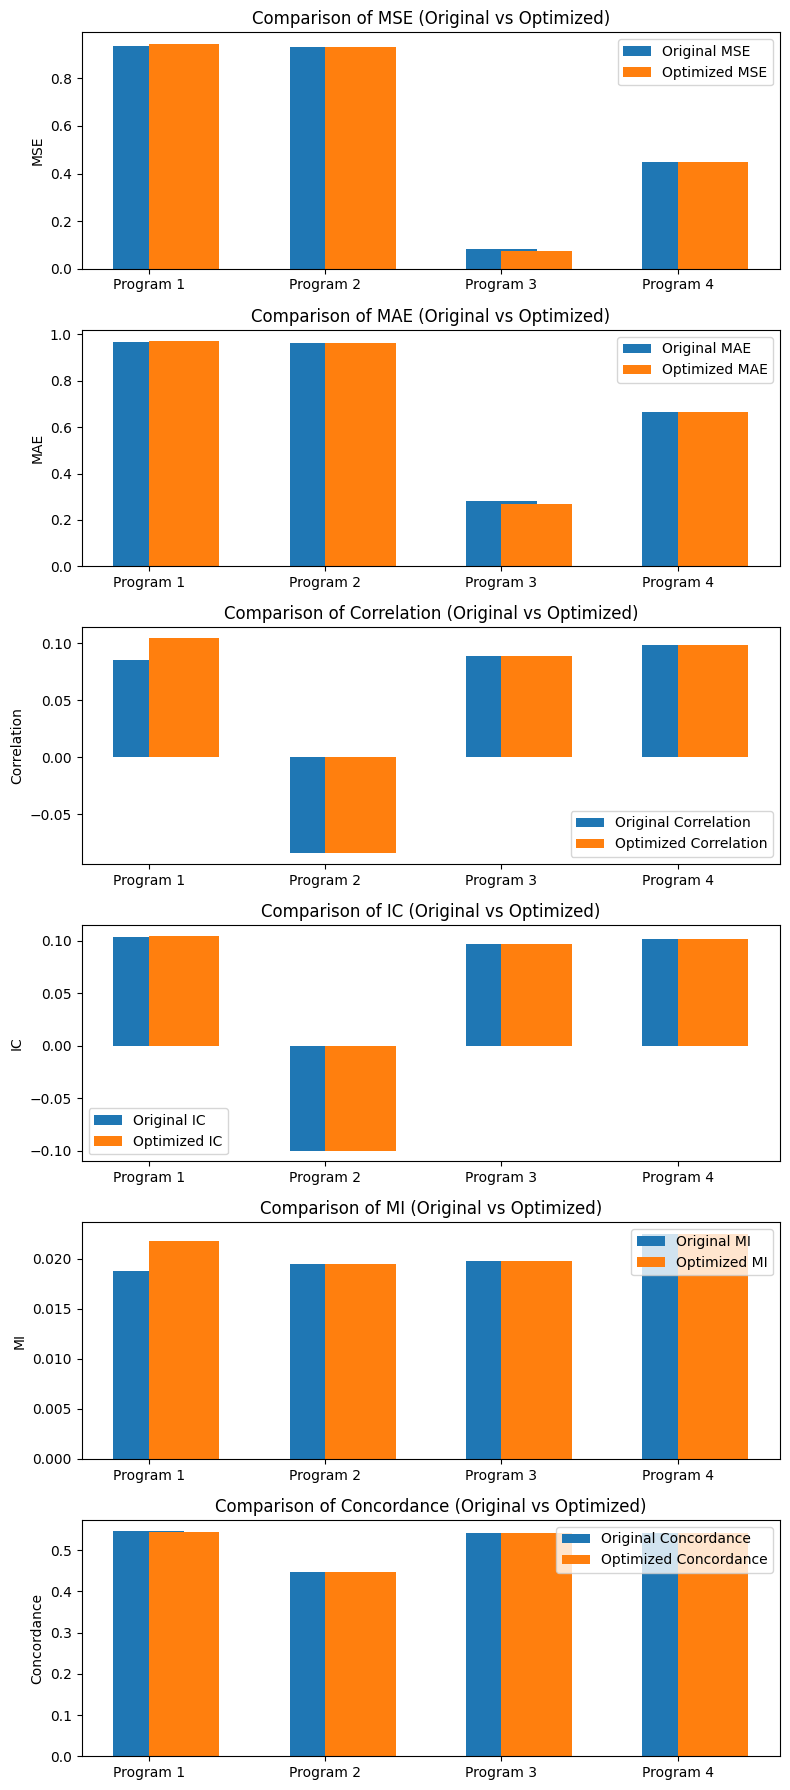

In [1]:
# Re-import necessary libraries and re-run the plotting logic after environment reset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Data for original and optimized metrics
data = {
    'Program': ['Program 1', 'Program 2', 'Program 3', 'Program 4'],
    'MSE (Original)': [0.935819, 0.931001, 0.081874, 0.447531],
    'MAE (Original)': [0.965659, 0.963593, 0.282932, 0.666517],
    'Correlation (Original)': [0.085429, -0.083972, 0.088513, 0.098179],
    'IC (Original)': [0.103572, -0.099817, 0.097162, 0.101388],
    'MI (Original)': [0.018784, 0.019473, 0.019743, 0.022517],
    'Concordance (Original)': [0.545878, 0.445962, 0.542381, 0.541715],

    'MSE (Optimized)': [0.945687, 0.931001, 0.074635, 0.447531],
    'MAE (Optimized)': [0.971276, 0.963593, 0.269861, 0.666517],
    'Correlation (Optimized)': [0.104425, -0.083972, 0.088513, 0.098179],
    'IC (Optimized)': [0.104865, -0.099817, 0.097163, 0.101388],
    'MI (Optimized)': [0.021753, 0.019473, 0.019743, 0.022517],
    'Concordance (Optimized)': [0.543381, 0.445962, 0.542381, 0.541715],
}

# Create a DataFrame
df = pd.DataFrame(data)

# Define a list of metrics to compare
metrics = ['MSE', 'MAE', 'Correlation', 'IC', 'MI', 'Concordance']

# Create subplots to compare original vs. optimized metrics for each program
fig, axs = plt.subplots(len(metrics), 1, figsize=(8, 18))

# Plotting each metric
for i, metric in enumerate(metrics):
    axs[i].bar(df['Program'], df[f'{metric} (Original)'], width=0.4, label=f'Original {metric}', align='center')
    axs[i].bar(df['Program'], df[f'{metric} (Optimized)'], width=0.4, label=f'Optimized {metric}', align='edge')
    axs[i].set_ylabel(metric)
    axs[i].legend()
    axs[i].set_title(f'Comparison of {metric} (Original vs Optimized)')

plt.tight_layout()
plt.show()
